# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Explaining-Decision-Trees-and-Random-Forests" data-toc-modified-id="Explaining-Decision-Trees-and-Random-Forests-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Explaining Decision Trees and Random Forests</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#How-Do-Decision-Trees-Work?" data-toc-modified-id="How-Do-Decision-Trees-Work?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>How Do Decision Trees Work?</a></div><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Create-Feature-Contribution" data-toc-modified-id="Create-Feature-Contribution-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create Feature Contribution</a></div><div class="lev1 toc-item"><a href="#Visualizing-Decision-Trees" data-toc-modified-id="Visualizing-Decision-Trees-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualizing Decision Trees</a></div><div class="lev1 toc-item"><a href="#Contributions" data-toc-modified-id="Contributions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Contributions</a></div><div class="lev2 toc-item"><a href="#Regression-Contributions" data-toc-modified-id="Regression-Contributions-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Regression Contributions</a></div><div class="lev2 toc-item"><a href="#Decision-Tree-Features-vs.-Contributions" data-toc-modified-id="Decision-Tree-Features-vs.-Contributions-72"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Decision Tree Features vs. Contributions</a></div><div class="lev2 toc-item"><a href="#Extending-to-Random-Forests" data-toc-modified-id="Extending-to-Random-Forests-73"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Extending to Random Forests</a></div><div class="lev2 toc-item"><a href="#Multi-class-classification" data-toc-modified-id="Multi-class-classification-74"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Multi-class classification</a></div>

# Explaining Decision Trees and Random Forests

This notebook shows examples of how the `treeinterpreter` (<a href='https://github.com/andosa/treeinterpreter'>https://github.com/andosa/treeinterpreter</a>) library works and provides some insightful plots to gain a deeper understanding of what a decision tree or random forest is doing.

I have created a set of useful plotting functions in the file `tree_interp_functions.py`.

# Import Libraries

In [1]:
from __future__ import division

from IPython.display import Image, display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,\
                         export_graphviz
from treeinterpreter import treeinterpreter as ti
import pydotplus
import collections
from tree_interp_functions import *
from scipy.special import logit, expit

In [2]:
# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
sns.set_style('darkgrid')
sns.set_palette('colorblind')
blue, green, red, purple, yellow, cyan = sns.color_palette('colorblind')

# How Do Decision Trees Work?

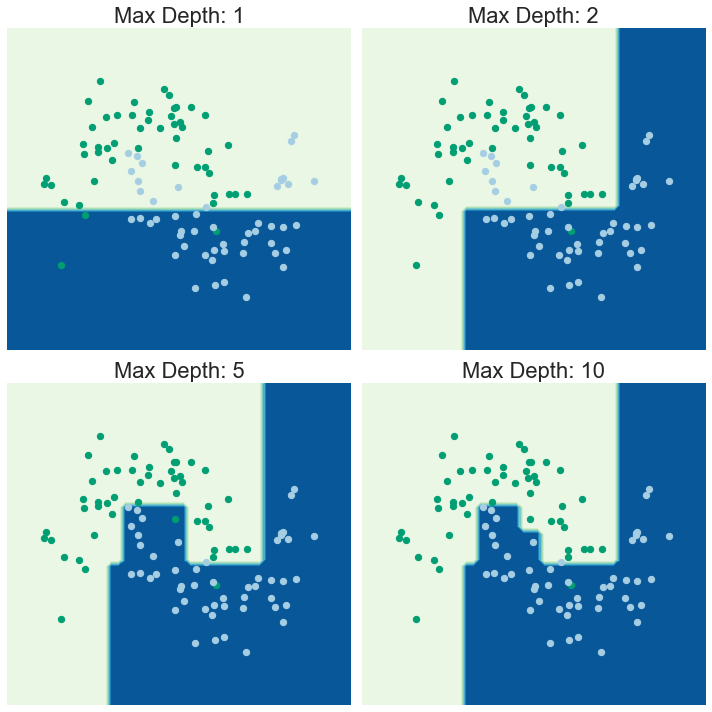

In [3]:
light_blue, dark_blue, light_green, dark_green, light_red, dark_red = sns.color_palette('Paired')
x, z = make_moons(noise=0.20, random_state=5)
df = pd.DataFrame({'z': z,
                   'x': x[:, 0],
                   'y': x[:, 1]
                  })

md_list = [1, 2, 5, 10]
fig, ax = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(10)
for i in range(len(md_list)):
    md = md_list[i]
    ix_0 = int(np.floor(i/2))
    ix_1 = i%2
    
    circle_dt_clf = DecisionTreeClassifier(max_depth=md, random_state=0)
    circle_dt_clf.fit(df[['x', 'y']], df['z'])

    xx, yy = np.meshgrid(np.linspace(df.x.min() - 0.5, df.x.max() + 0.5, 50),
                         np.linspace(df.y.min() - 0.5, df.y.max() + 0.5, 50))
    zz = list(zip(xx.reshape(-1), yy.reshape(-1)))
    z_pred = circle_dt_clf.predict(zz)
    z_pred = np.array([int(j) for j in z_pred.reshape(-1)])\
        .reshape(len(xx), len(yy))

    ax[ix_0, ix_1].contourf(xx, yy, z_pred, cmap=plt.get_cmap('GnBu'))

    df.query('z == 0').plot('x', 'y', kind='scatter',
                            s=40, c=green, ax=ax[ix_0, ix_1])
    df.query('z == 1').plot('x', 'y', kind='scatter',
                            s=40, c=light_blue, ax=ax[ix_0, ix_1])
    
    ax[ix_0, ix_1].set_title('Max Depth: {}'.format(md))
    ax[ix_0, ix_1].set_xticks([], [])
    ax[ix_0, ix_1].set_yticks([], [])
    ax[ix_0, ix_1].set_xlabel('')
    ax[ix_0, ix_1].set_ylabel('')

plt.tight_layout()
plt.savefig('plots/dt_iterations.png')

# Load Data
We will use the abalone data set as an example. We would like to show how this works for decision tree and random forest regressors as well as classifiers. We use the `rings` variable as our continuous variable and create a binary variable from it to indicate whether `rings > 9`.

In [4]:
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone_df = pd.read_csv('abalone.csv', names=column_names)
abalone_df['sex'] = abalone_df['sex'].map({'F': 0, 'M': 1, 'I': 2})
abalone_df['y'] = abalone_df.rings.map(lambda x: 1 if x > 9 else 0)
abalone_df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,y
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


Here, we do a simple train/test split of the data.

In [5]:
abalone_train, abalone_test = train_test_split(abalone_df, test_size=0.2,
                                               random_state=0)

X_train = abalone_train.drop(['sex', 'rings', 'y'], axis=1)
y_train_bin_clf = abalone_train.y
y_train_multi_clf = abalone_train.sex
y_train_reg = abalone_train.rings

X_test = abalone_test.drop(['sex', 'rings', 'y'], axis=1)
y_test_bin_clf = abalone_test.y
y_test_multi_clf = abalone_test.sex
y_test_reg = abalone_test.rings

X_train = X_train.copy().reset_index(drop=True)
y_train_bin_clf = y_train_bin_clf.copy().reset_index(drop=True)
y_train_multi_clf = y_train_multi_clf.copy().reset_index(drop=True)
y_train_reg = y_train_reg.copy().reset_index(drop=True)

X_test = X_test.copy().reset_index(drop=True)
y_test_bin_clf = y_test_bin_clf.copy().reset_index(drop=True)
y_test_multi_clf = y_test_multi_clf.copy().reset_index(drop=True)
y_test_reg = y_test_reg.copy().reset_index(drop=True)

# Build Model
Now, we build simple decision tree and random forest models. We will limit the depth of the decision tree to show how the interpretation works.

In [6]:
dt_bin_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                    random_state=0)
dt_bin_clf.fit(X_train, y_train_bin_clf)

dt_multi_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2,
                                      random_state=0)
dt_multi_clf.fit(X_train, y_train_multi_clf)

dt_reg = DecisionTreeRegressor(criterion='mse', max_depth=3,
                               random_state=0)
dt_reg.fit(X_train, y_train_reg)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [7]:
rf_bin_clf = RandomForestClassifier(criterion='entropy', max_depth=33,
                                    n_estimators=100, random_state=0)
rf_bin_clf.fit(X_train, y_train_bin_clf)

rf_multi_clf = RandomForestClassifier(criterion='entropy', max_depth=3,
                                      n_estimators=100, random_state=0)
rf_multi_clf.fit(X_train, y_train_multi_clf)

rf_reg = RandomForestRegressor(criterion='mse', max_depth=3,
                               n_estimators=100, random_state=0)
rf_reg.fit(X_train, y_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [64]:
gbt_bin_clf = GradientBoostingClassifier(max_depth=2, n_estimators=5, random_state=0)
gbt_bin_clf.fit(X_train, y_train_bin_clf)
gbt_reg = GradientBoostingRegressor(max_depth=2, n_estimators=5, random_state = 0)
gbt_reg.fit(X_train, y_train_reg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5, presort='auto', random_state=0, subsample=1.0,
             verbose=0, warm_start=False)

## Create Feature Contribution
We use the `ti.predict` function to get our predictions, biases, and contributions. The contributions matrix is a 3d array which represents the contribution for each example, feature, and class label.

In [65]:
dt_bin_clf_pred, dt_bin_clf_bias, dt_bin_clf_contrib = ti.predict(dt_bin_clf, X_test)
rf_bin_clf_pred, rf_bin_clf_bias, rf_bin_clf_contrib = ti.predict(rf_bin_clf, X_test)
gbt_bin_clf_pred, gbt_bin_clf_bias, gbt_bin_clf_contrib, gbt_bin_clf_pred2 = ti.predict(gbt_bin_clf, X_test)

dt_multi_clf_pred, dt_multi_clf_bias, dt_multi_clf_contrib = ti.predict(dt_multi_clf, X_test)
rf_multi_clf_pred, rf_multi_clf_bias, rf_multi_clf_contrib = ti.predict(rf_multi_clf, X_test)

dt_reg_pred, dt_reg_bias, dt_reg_contrib = ti.predict(dt_reg, X_test)
rf_reg_pred, rf_reg_bias, rf_reg_contrib = ti.predict(rf_reg, X_test)
gbt_reg_pred, gbt_reg_bias, gbt_reg_contrib, gbt_reg_pred2 = ti.predict(gbt_reg, X_test)

In [66]:
compareGBT = list(zip(expit(gbt_bin_clf_pred), expit(gbt_bin_clf_pred2)))

In [67]:
gbt_bin_clf_orig_proba = gbt_bin_clf.predict_proba(X_test)
gbt_bin_clf_orig_pred = gbt_bin_clf.predict(X_test)
gbt_reg_orig_pred = gbt_reg.predict(X_test)

In [68]:
expit(gbt_bin_clf_pred2)

array([0.62113466, 0.45039387, 0.57969287, 0.33758024, 0.63966344,
       0.62113466, 0.37225593, 0.45039387, 0.33758024, 0.62113466,
       0.37225593, 0.33758024, 0.33758024, 0.45039387, 0.33758024,
       0.55637305, 0.33758024, 0.62113466, 0.62113466, 0.37225593,
       0.33758024, 0.33758024, 0.39858468, 0.33758024, 0.55637305,
       0.55637305, 0.33758024, 0.65648552, 0.49145682, 0.55637305,
       0.33758024, 0.33758024, 0.55637305, 0.65648552, 0.33758024,
       0.45039387, 0.39858468, 0.55637305, 0.37225593, 0.63966344,
       0.55637305, 0.45039387, 0.55637305, 0.55637305, 0.62113466,
       0.39858468, 0.49145682, 0.63966344, 0.57969287, 0.33758024,
       0.57969287, 0.33758024, 0.37225593, 0.65648552, 0.45039387,
       0.37225593, 0.33758024, 0.33758024, 0.33758024, 0.33758024,
       0.55637305, 0.49145682, 0.55637305, 0.37225593, 0.33758024,
       0.65648552, 0.65648552, 0.65648552, 0.49145682, 0.65648552,
       0.45039387, 0.65648552, 0.62113466, 0.49145682, 0.49145

In [69]:
sum_gbt = np.zeros(gbt_bin_clf_orig_pred.shape[0]) 
isFirst = True 
norm = 0
learning_rate = gbt_bin_clf.learning_rate
print(gbt_bin_clf.n_estimators)
for ii in range(gbt_bin_clf.n_estimators):
    #print(gbt_bin_clf.estimators_[ii][0].predict(X_test)[0])
    if isFirst:
        sum_gbt += (learning_rate * gbt_bin_clf.estimators_[ii][0].predict(X_test))
        isFirst = False
        norm += learning_rate
    else:
        sum_gbt += (learning_rate * gbt_bin_clf.estimators_[ii][0].predict(X_test))
        norm += learning_rate
#print("Norm: " + str(norm))
#print("Sum: " + str(sum_gbt))
#print("Sum/Norm: " + str(sum_gbt/norm))
#print("Result: " + str(expit(sum_gbt/norm)))
#print("Target: 0.67489087")

5


In [77]:
gbt_bin_clf_orig_proba.shape

(836, 2)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 836.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
        -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
        -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
        -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
        -0.14, -0.13, -0.12, -0.11

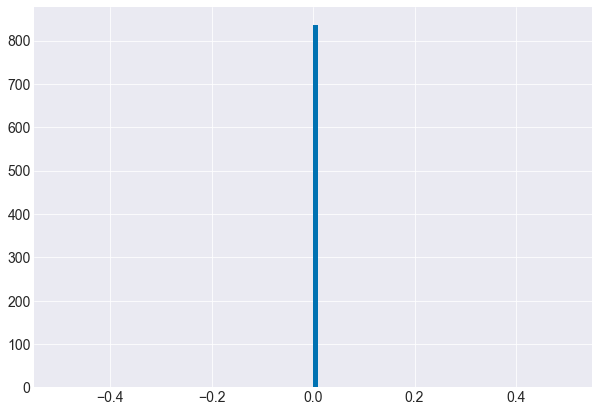

In [70]:
plt.hist(gbt_bin_clf_orig_proba[:, 1]-expit(gbt_bin_clf_pred2), np.linspace(-0.5, 0.5, 101))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  48.,  58.,  39., 105., 101.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 119.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 274.,   0.,   0.,  70.,   3.,
         19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
        -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
        -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
        -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
        -0.14, -0.13, -0.12, -0.11

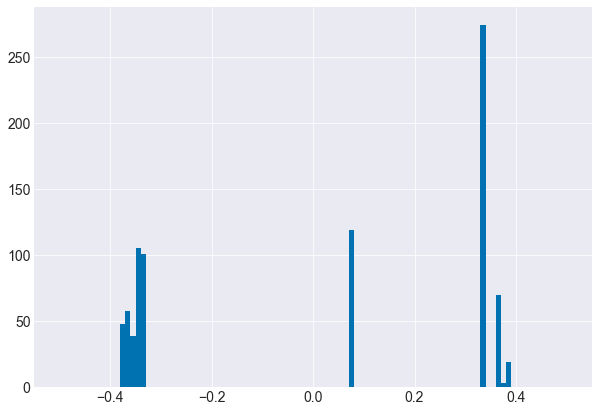

In [76]:
plt.hist(gbt_bin_clf_orig_proba[:, 1]-expit(gbt_bin_clf_pred), np.linspace(-0.5, 0.5, 101))

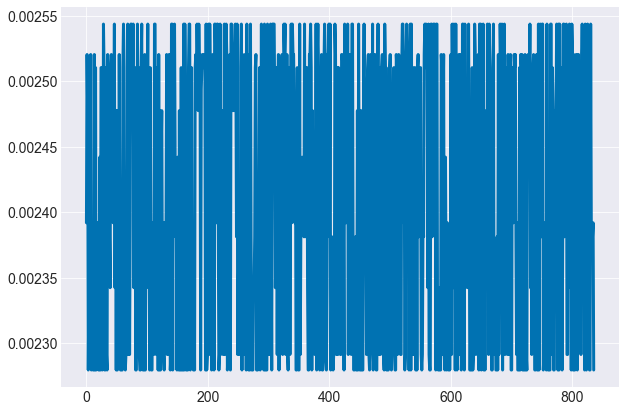

In [78]:
plt.plot(gbt_bin_clf_orig_proba[:, 1]-expit(gbt_bin_clf_pred2))

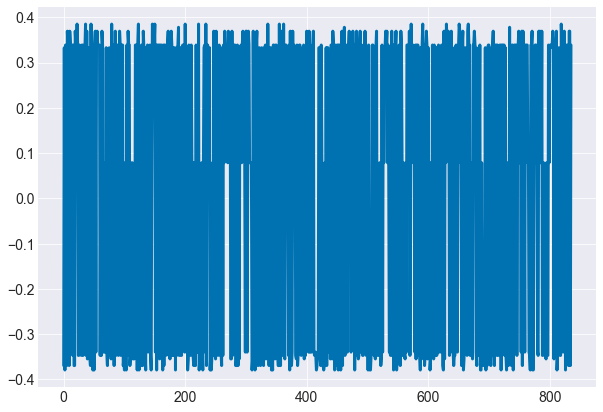

In [80]:
plt.plot(gbt_bin_clf_orig_proba[:, 1]-expit(gbt_bin_clf_pred))

# Visualizing Decision Trees
We can visualize a decision tree by using graphviz. This will show every path down to the leaves and the proportion of the two classes in each node.

In [ ]:
reg_dot_data = export_graphviz(dt_reg,
                               out_file=None,
                               feature_names=X_train.columns
                              )
reg_graph = pydotplus.graph_from_dot_data(reg_dot_data)
reg_graph.write_png('plots/reg_dt_path.png')
Image(reg_graph.create_png())

In [ ]:
bin_clf_dot_data = export_graphviz(dt_bin_clf,
                                   out_file=None,
                                   feature_names=X_train.columns
                                  )
bin_clf_graph = pydotplus.graph_from_dot_data(bin_clf_dot_data)
reg_graph.write_png('plots/bin_clf_dt_path.png')
Image(bin_clf_graph.create_png())

In [ ]:
multi_clf_dot_data = export_graphviz(dt_multi_clf,
                                     out_file=None,
                                     feature_names=X_train.columns
                                    )
multi_clf_graph = pydotplus.graph_from_dot_data(multi_clf_dot_data)
multi_clf_graph.write_png('plots/multi_clf_dt_path.png')
Image(multi_clf_graph.create_png())

# Contributions

## Regression Contributions

In [ ]:
# Find abalones that are in the left-most leaf
X_test[(X_test['shell weight'] <= 0.0587) & (X_test['length'] <= 0.2625)].head()

In [ ]:
df, true_label, pred = plot_obs_feature_contrib(dt_reg,
                                                dt_reg_contrib,
                                                X_test,
                                                y_test_reg,
                                                3,
                                                order_by='contribution'
                                               )
plt.tight_layout()
plt.savefig('plots/contribution_plot_dt_reg.png')

In [ ]:
df, true_label, score = plot_obs_feature_contrib(dt_reg,
                                                 dt_reg_contrib,
                                                 X_test,
                                                 y_test_reg,
                                                 3,
                                                 order_by='contribution',
                                                 violin=True
                                                )
plt.tight_layout()
plt.savefig('plots/contribution_plot_violin_dt_reg.png')

## Decision Tree Features vs. Contributions

In [ ]:
plot_single_feat_contrib('shell weight', dt_reg_contrib, X_test, class_index=1)
plt.savefig('plots/shell_weight_contribution_dt.png')

In [ ]:
plot_single_feat_contrib('shucked weight', dt_reg_contrib, X_test, class_index=1)
plt.savefig('plots/shucked_weight_contribution_dt.png')

## Extending to Random Forests

In [ ]:
df, true_label, pred = plot_obs_feature_contrib(rf_reg,
                                                rf_reg_contrib,
                                                X_test,
                                                y_test_reg,
                                                3,
                                                order_by='contribution'
                                               )
plt.tight_layout()
plt.savefig('plots/contribution_plot_rf.png')

In [ ]:
df = plot_obs_feature_contrib(rf_reg,
                              rf_reg_contrib,
                              X_test,
                              y_test_reg,
                              3,
                              order_by='contribution',
                              violin=True
                             )
plt.tight_layout()
plt.savefig('plots/contribution_plot_violin_rf.png')

In [ ]:
plot_single_feat_contrib('shell weight', rf_reg_contrib, X_test,
                         class_index=1, add_smooth=True, frac=0.3)
plt.savefig('plots/shell_weight_contribution_rf.png')

In [ ]:
plot_single_feat_contrib('shucked weight', rf_reg_contrib, X_test,
                         class_index=1, add_smooth=True, frac=0.3)
plt.savefig('plots/shucked_weight_contribution_rf.png')

In [ ]:
abalone_test.plot(x='shucked weight', y='rings', kind='scatter')
plt.title('Number of Rings vs. Shucked Weight')
plt.ylabel('Number of Rings')
plt.tight_layout()

plt.savefig('plots/num_rings_vs_shucked_weight.png')

In [ ]:
plot_single_feat_contrib('diameter', rf_reg_contrib, X_test,
                         class_index=1, add_smooth=True, frac=0.3)
plt.savefig('plots/diameter_contribution_rf.png')

## Compare Gradient Boosted Trees to RF and DT

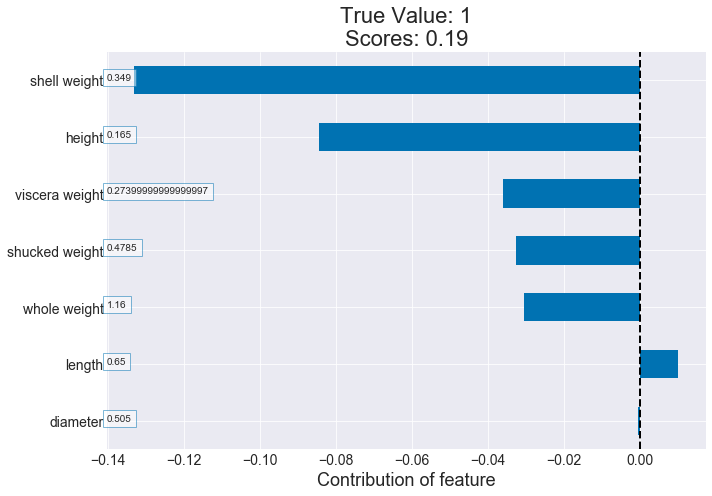

In [81]:
df2, true_label2, pred2 = plot_obs_feature_contrib(rf_bin_clf,
                                                rf_bin_clf_contrib,
                                                X_test,
                                                y_test_bin_clf,
                                                5,
                                                order_by='contribution'
                                               )
plt.tight_layout()
plt.savefig('plots/contribution_plot_rf_class.png')

[0.376, 0.624]


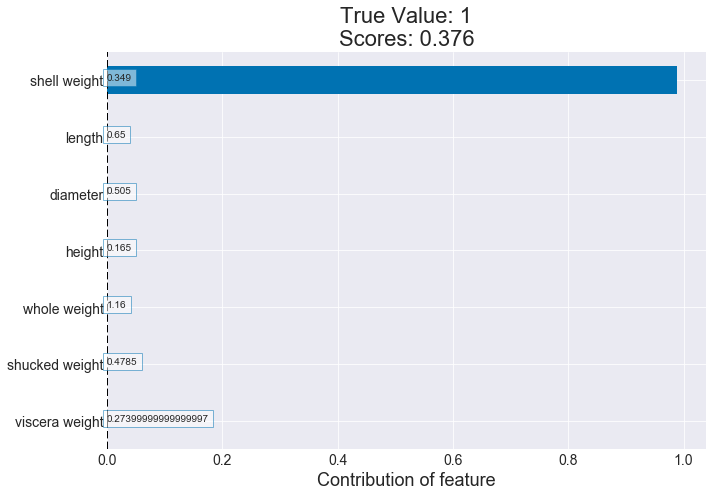

In [82]:
df3, true_label3, pred3 = plot_obs_feature_contrib(gbt_bin_clf,
                                                gbt_bin_clf_contrib,
                                                X_test,
                                                y_test_bin_clf,
                                                5,
                                                order_by='contribution'
                                               )
plt.tight_layout()
plt.savefig('plots/contribution_plot_gbt_class.png')

In [87]:
gbt_bin_clf_contrib[5]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.98874212])

In [89]:
gbt_bin_clf_bias

array([-8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -8.02629504e-05, -8.02629504e-05, -8.02629504e-05,
       -8.02629504e-05, -

In [ ]:
gbt_clf_dot_data0 = export_graphviz(gbt_bin_clf.estimators_[0][0],
                                   out_file=None,
                                   feature_names=X_train.columns
                                  )
gbt_clf_graph0 = pydotplus.graph_from_dot_data(gbt_clf_dot_data0)
reg_graph.write_png('plots/bin_clf_gbt0_path.png')
Image(gbt_clf_graph0.create_png())

In [ ]:
gbt_clf_dot_data1 = export_graphviz(gbt_bin_clf.estimators_[1][0],
                                   out_file=None,
                                   feature_names=X_train.columns
                                  )
gbt_clf_graph1 = pydotplus.graph_from_dot_data(gbt_clf_dot_data1)
reg_graph.write_png('plots/bin_clf_gbt1_path.png')
Image(gbt_clf_graph1.create_png())

In [ ]:
gbt_clf_dot_data99 = export_graphviz(gbt_bin_clf.estimators_[99][0],
                                   out_file=None,
                                   feature_names=X_train.columns
                                  )
gbt_clf_graph99 = pydotplus.graph_from_dot_data(gbt_clf_dot_data99)
reg_graph.write_png('plots/bin_clf_gbt99_path.png')
Image(gbt_clf_graph99.create_png())

In [ ]:
gbt_clf_dot_data199 = export_graphviz(gbt_bin_clf.estimators_[199][0],
                                   out_file=None,
                                   feature_names=X_train.columns
                                  )
gbt_clf_graph199 = pydotplus.graph_from_dot_data(gbt_clf_dot_data199)
reg_graph.write_png('plots/bin_clf_gbt199_path.png')
Image(gbt_clf_graph199.create_png())

## Multi-class classification

In [ ]:
X_test[(X_test['viscera weight'] <= 0.1622) & (X_test['shell weight'] <= 0.1285)].head()

In [ ]:
df, true_label, scores = plot_obs_feature_contrib(dt_multi_clf,
                                                  dt_multi_clf_contrib,
                                                  X_test,
                                                  y_test_multi_clf,
                                                  3,
                                                  class_index=2,
                                                  order_by='contribution'
                                                 )
true_value_list = ['Female', 'Male', 'Infant']
score_dict = zip(true_value_list, scores)
title = 'True Value: {}\nScores: {}'.format(true_value_list[true_label],
                                            ', '.join(['{} - {}'.format(i, j) for i, j in score_dict]))
plt.title(title)
plt.savefig('plots/contribution_plot_multi_clf_dt.png')

In [ ]:
df, true_label, scores = plot_obs_feature_contrib(dt_multi_clf,
                                                  dt_multi_clf_contrib,
                                                  X_test,
                                                  y_test_multi_clf,
                                                  3,
                                                  class_index=2,
                                                  order_by='contribution',
                                                  violin=True
                                                 )
true_value_list = ['Female', 'Male', 'Infant']
score_dict = zip(true_value_list, scores)
title = 'Contributions for Infant Class\nTrue Value: {}\nScores: {}'.format(true_value_list[true_label],
                                            ', '.join(['{} - {}'.format(i, j) for i, j in score_dict]))
plt.title(title)
plt.tight_layout()
plt.savefig('plots/contribution_plot_violin_multi_clf_dt.png')

In [ ]:
print(0.5904 - 0.3146)
print(0.7469 - 0.5904)

df

In [ ]:
colours = [blue, green, red]
class_names = ['Sex = {}'.format(s) for s in ('F', 'M', 'I')]

fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(20)

for i in range(3):
    plot_single_feat_contrib('shell weight', dt_multi_clf_contrib, X_test,
                             class_index=i, class_name=class_names[i],
                             c=colours[i], ax=ax[i])
    
plt.tight_layout()
plt.savefig('plots/shell_weight_contribution_by_sex_dt.png')

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(20)

for i in range(3):
    plot_single_feat_contrib('shell weight', rf_multi_clf_contrib, X_test,
                             class_index=i, class_name=class_names[i],
                             add_smooth=True, c=colours[i], ax=ax[i])
    
plt.tight_layout()
plt.savefig('plots/shell_weight_contribution_by_sex_rf.png')